In [115]:
import scipy
import numpy as np
from fitters import *
from tools import *
from plots import *
from projectors import *
set_seaborn()
sns.set_theme()
%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [116]:
resPH, stimPH = read_lmc('PHOTO')
res1, stim3 = read_lmc('LMC-BG1')
res2, stim3 = read_lmc('LMC-BG2')
res3, stim3 = read_lmc('LMC-BG3')
res4, stim4 = read_lmc('LMC-BG4')
res5, stim5 = read_lmc('LMC-BG5')
res6, stim6 = read_lmc('LMC-BG6')

TIME = 1.0
all_results = []

In [117]:
def get_data(Ydataset, factor, Xdataset='PHOTO'):
    resX, stim = read_lmc(Xdataset)
    resY, stim = read_lmc(Ydataset)
    X = preprocess(resX, factor=factor, method='mean')
    Y = preprocess(resY, factor=factor, method='mean')

    return X, Y


In [118]:
def convert_dtms_windowms_to_factor_dim(dt, window, TIME=1.0, LEN=10000):
    orignal_dt_ms = TIME/LEN * 1000
    factor = int(dt/orignal_dt_ms)
    dim = int(window / dt)
    return factor, dim


In [119]:
import torch

def L1_solve_torch(X0, Xp):
    
    A_init = (Xp @ X0.T) @ np.linalg.inv((X0 @ X0.T))

    SolL1T = torch.tensor(A_init, requires_grad=True)
    X0T = torch.tensor(X0)
    opt = torch.optim.Adam([SolL1T], lr=0.001)
    X0T = torch.tensor(X0)
    XpT = torch.tensor(Xp)
    loss_hist = []
    for _ in range(10000):
        loss = (XpT - SolL1T @ X0T).abs().sum()
        loss_hist.append(loss.item())
        opt.zero_grad()
        loss.backward()
        opt.step()
    SolL1 = SolL1T.data.numpy()
    return SolL1


In [120]:
from scipy.optimize import minimize
import numpy as np

def L1_solve(X0, Xp):
    A_init = (Xp @ X0.T) @ np.linalg.inv((X0 @ X0.T))

    def cost_function(A, X, y):

        s = int(np.sqrt(len(A)))
        A = np.reshape(A, (s,s))
        return np.sum(np.abs(y - A @ X ))


    output = minimize(cost_function, A_init, args=(X0, Xp))

    A = output.x

    res = cost_function(A, X0, Xp)
    s = int(np.sqrt(len(A)))
    A = np.reshape(A, (s,s))
    return A
  

In [130]:

def test_run(beta=0, dt_ms=1.0, lag_ms=50, method='eig', top_i=1, dataset='', normalize='none', window_factor=2.0):

    factor, dim = convert_dtms_windowms_to_factor_dim(dt_ms, lag_ms)
    X_series, Y_series = get_data(dataset, factor)

    time = np.linspace(0, 1, len(X_series))

    if normalize == 'mean':
        X_series -= X_series.mean()
        Y_series -= Y_series.mean()
    elif normalize == '01':
        X_series, Y_series = normalize_01(X_series), normalize_01(Y_series)

    if method == 'eig':
        Xhan = build_hankel(X_series, dim)
        X0 = Xhan[:, :-1]
        Xp = Xhan[:, 1:]
        lam = beta * np.eye(dim)

        X0Xp = X0 @ Xp.T
        X0X0 = X0 @ X0.T
        # solve eigenvalue problem
        w, vl = scipy.linalg.eig(X0Xp, (X0X0+lam))

        sortorder = np.argsort(w)
        thetas = vl[:, sortorder][:, ::-1]
        # theta = thetas[:, -2]
        w = w[sortorder][::-1]

        thetas[:, :top_i] *= thetas[:, :top_i][-1]
        theta = np.mean(thetas[:, :top_i], axis=-1)

        P_series = theta.real @ Xhan

    elif method == 'eig-comp':
        Xhan = build_hankel(X_series, dim)
        X0 = Xhan[:, :-1]
        Xp = Xhan[:, 1:]
        Xp = Xp[-1]
        lam = beta * np.eye(dim)

        a = (Xp @ X0.T) @ np.linalg.inv((X0 @ X0.T) + lam)
        A = np.eye(dim, k=1)
        A[-1] = a
        w, vl = scipy.linalg.eig(A, left=True, right=False)

        sortorder = np.argsort(w)
        thetas = vl[:, sortorder][:, ::-1]
        # theta = thetas[:, -2]
        w = w[sortorder][::-1]

        thetas[:, :top_i] *= thetas[:, :top_i][-1]
        theta = np.mean(thetas[:, :top_i] * w[:top_i], axis=-1)

        P_series = theta.real @ Xhan

    elif method == 'eig-C':
        P_series, theta, A, c = eig_companion_Cshift(X_series, dim, beta=beta)

    elif method == 'eig-C-TIME':
    
        
        N = len(X_series)
        window = int(dim * window_factor)
        thetas = []
        for i in range(window, N, 1):
            P_series, theta, A, c = eig_companion_Cshift(X_series[i-window:i], dim, beta=beta)
            thetas.append(theta)

        Xhan = build_hankel(X_series, dim)
        theta = np.mean(thetas, axis=0)
        P_series = theta.real @ Xhan

    elif method == 'eig-C-TIME2':
        N = len(X_series)
        window = int(dim * window_factor)
        thetas = []
        Xhan = build_hankel(X_series, dim)
        P_series = np.zeros(Xhan.shape[0])
        for i in range(window, N, 1):
            P_series_w, theta, A, c = eig_companion_Cshift(X_series[i-window:i], dim, beta=beta)
            thetas.append(theta)
            print(P_series_w.shape, window, i-dim)
            P_series[i-window:i-dim] = P_series_w
               
        theta = np.mean(thetas, axis=0)

    elif method == 'svd':
        Xhan = build_hankel(X_series, dim)
        X0 = Xhan[:, :-1]
        Xp = Xhan[:, 1:]
        Xp = Xp[-1]
        lam = beta * np.eye(dim)

        a = (Xp @ X0.T) @ np.linalg.inv((X0 @ X0.T) + lam)
        A = np.eye(dim, k=1)
        A[-1] = a

        U, s, Vh = scipy.linalg.svd(A)
        theta = Vh[0, :]
        P_series = theta @ Xhan

    elif method == 'constant':
        # dim = 1
        # Xhan = build_hankel(X_series, dim)
        # theta = np.ones(dim)
        P_series = X_series[dim:]
        theta = np.ones(dim)

    elif method == 'L1':
        Xhan = build_hankel(X_series, dim)
        X0 = Xhan[:, :-1]
        Xp = Xhan[:, 1:]
        A = L1_solve_torch(X0, Xp)

        w, vl = scipy.linalg.eig(A, left=True, right=False)

        sortorder = np.argsort(w)
        thetas = vl[:, sortorder][:, ::-1]
        w = w[sortorder][::-1]
        thetas[:, :top_i] *= thetas[:, :top_i][-1]
        theta = np.mean(thetas[:, :top_i], axis=-1)
        P_series = theta.real @ Xhan

    elif method == 'DMD':
        Xhan = build_hankel(X_series, dim)
        X0 = Xhan[:, :-1]
        Xp = Xhan[:, 1:]
        r = dim // 2
        u, s, v = np.linalg.svd(X0, full_matrices=False)
        u, s, v = u[:, :r], s[:r], v[:r, :]

        s_inv = np.diag(1/s)

        A = u.conj().T @ Xp @ v.conj().T @ s_inv
        w, vl = scipy.linalg.eig(A, left=True, right=False)

        largest_evec_hat = vl[:, np.nanargmax(w)]
        theta = u @ largest_evec_hat
        P_series = theta.real @ Xhan

    Y_series = Y_series[dim:]
    P_series = solve_scale_shift(P_series, Y_series)

    err = mean_square_error(Y_series, P_series)  # / np.linalg.norm(Y_series)

    result = {
        'Time-X': time,
        'Time-Y': time[dim:],
        'Time-Filter': np.linspace(-lag_ms, 0, dim),
        'Theta (REAL)': theta.real,
        'Theta (IMAG)': theta.imag,
        'X_series': X_series,
        'Y_series': Y_series,
        'P_series': P_series,
        'err': err
    }
    return result


In [131]:
ALL_DATA = ['LMC-BG1', 'LMC-BG2', 'LMC-BG3', 'LMC-BG4', 'LMC-BG5', 'LMC-BG6']
params = {
    'dataset': ['LMC-BG1'],
    'window_factor': [1.6, 1.8, 2, 2.2, 2.4],
    'dt_ms': [1.0, 2.0, 3.0],
    'lag_ms': [25, 30, 35],
    'method': ['constant', 'eig', 'eig-C', 'eig-C-TIME', 'eig-C-TIME2'],

}
results = param_runner(test_run, params)


(15,) 40 15
(15,) 40 16
(15,) 40 17
(15,) 40 18
(15,) 40 19
(15,) 40 20
(15,) 40 21
(15,) 40 22
(15,) 40 23
(15,) 40 24
(15,) 40 25
(15,) 40 26


ValueError: could not broadcast input array from shape (15,) into shape (14,)

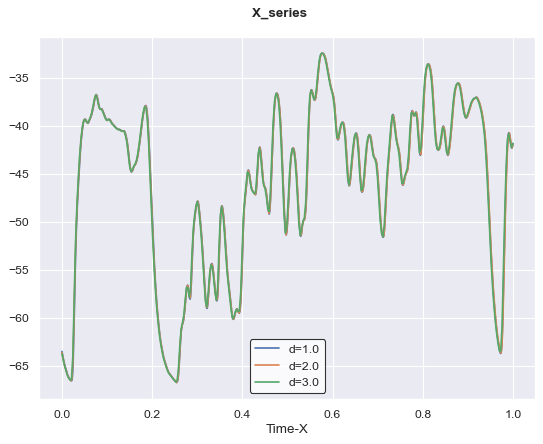

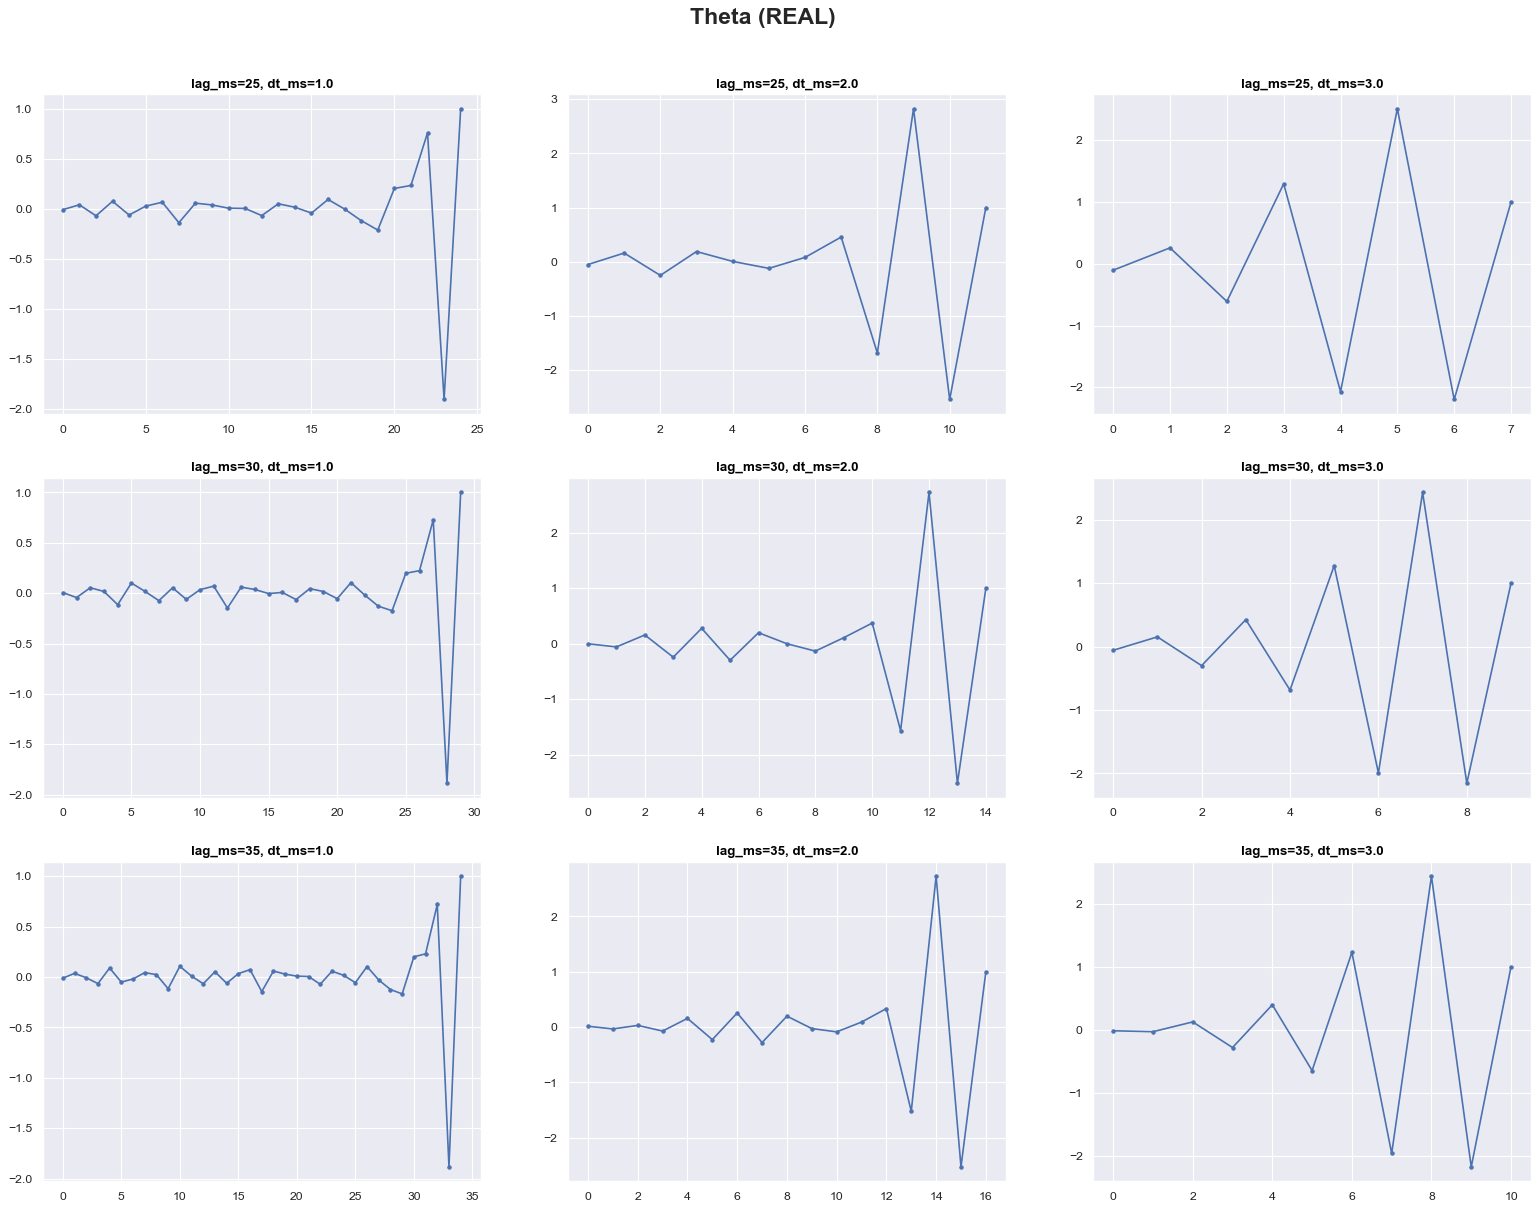

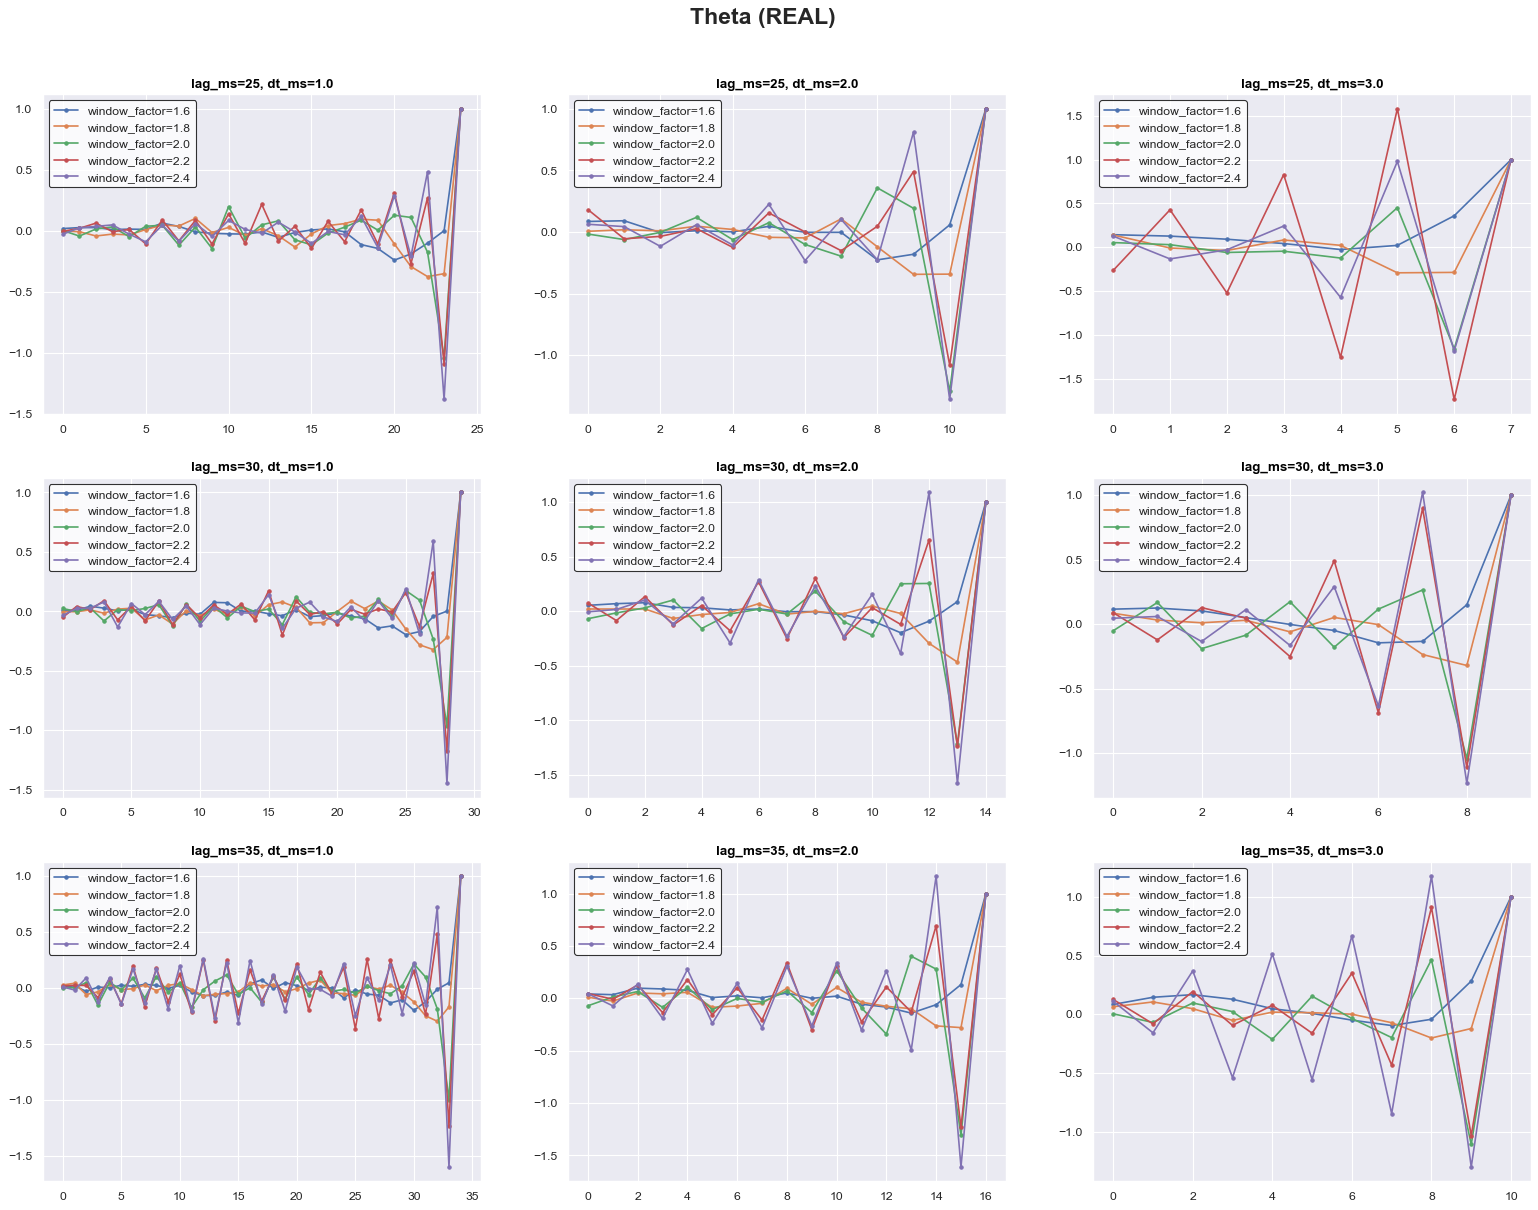

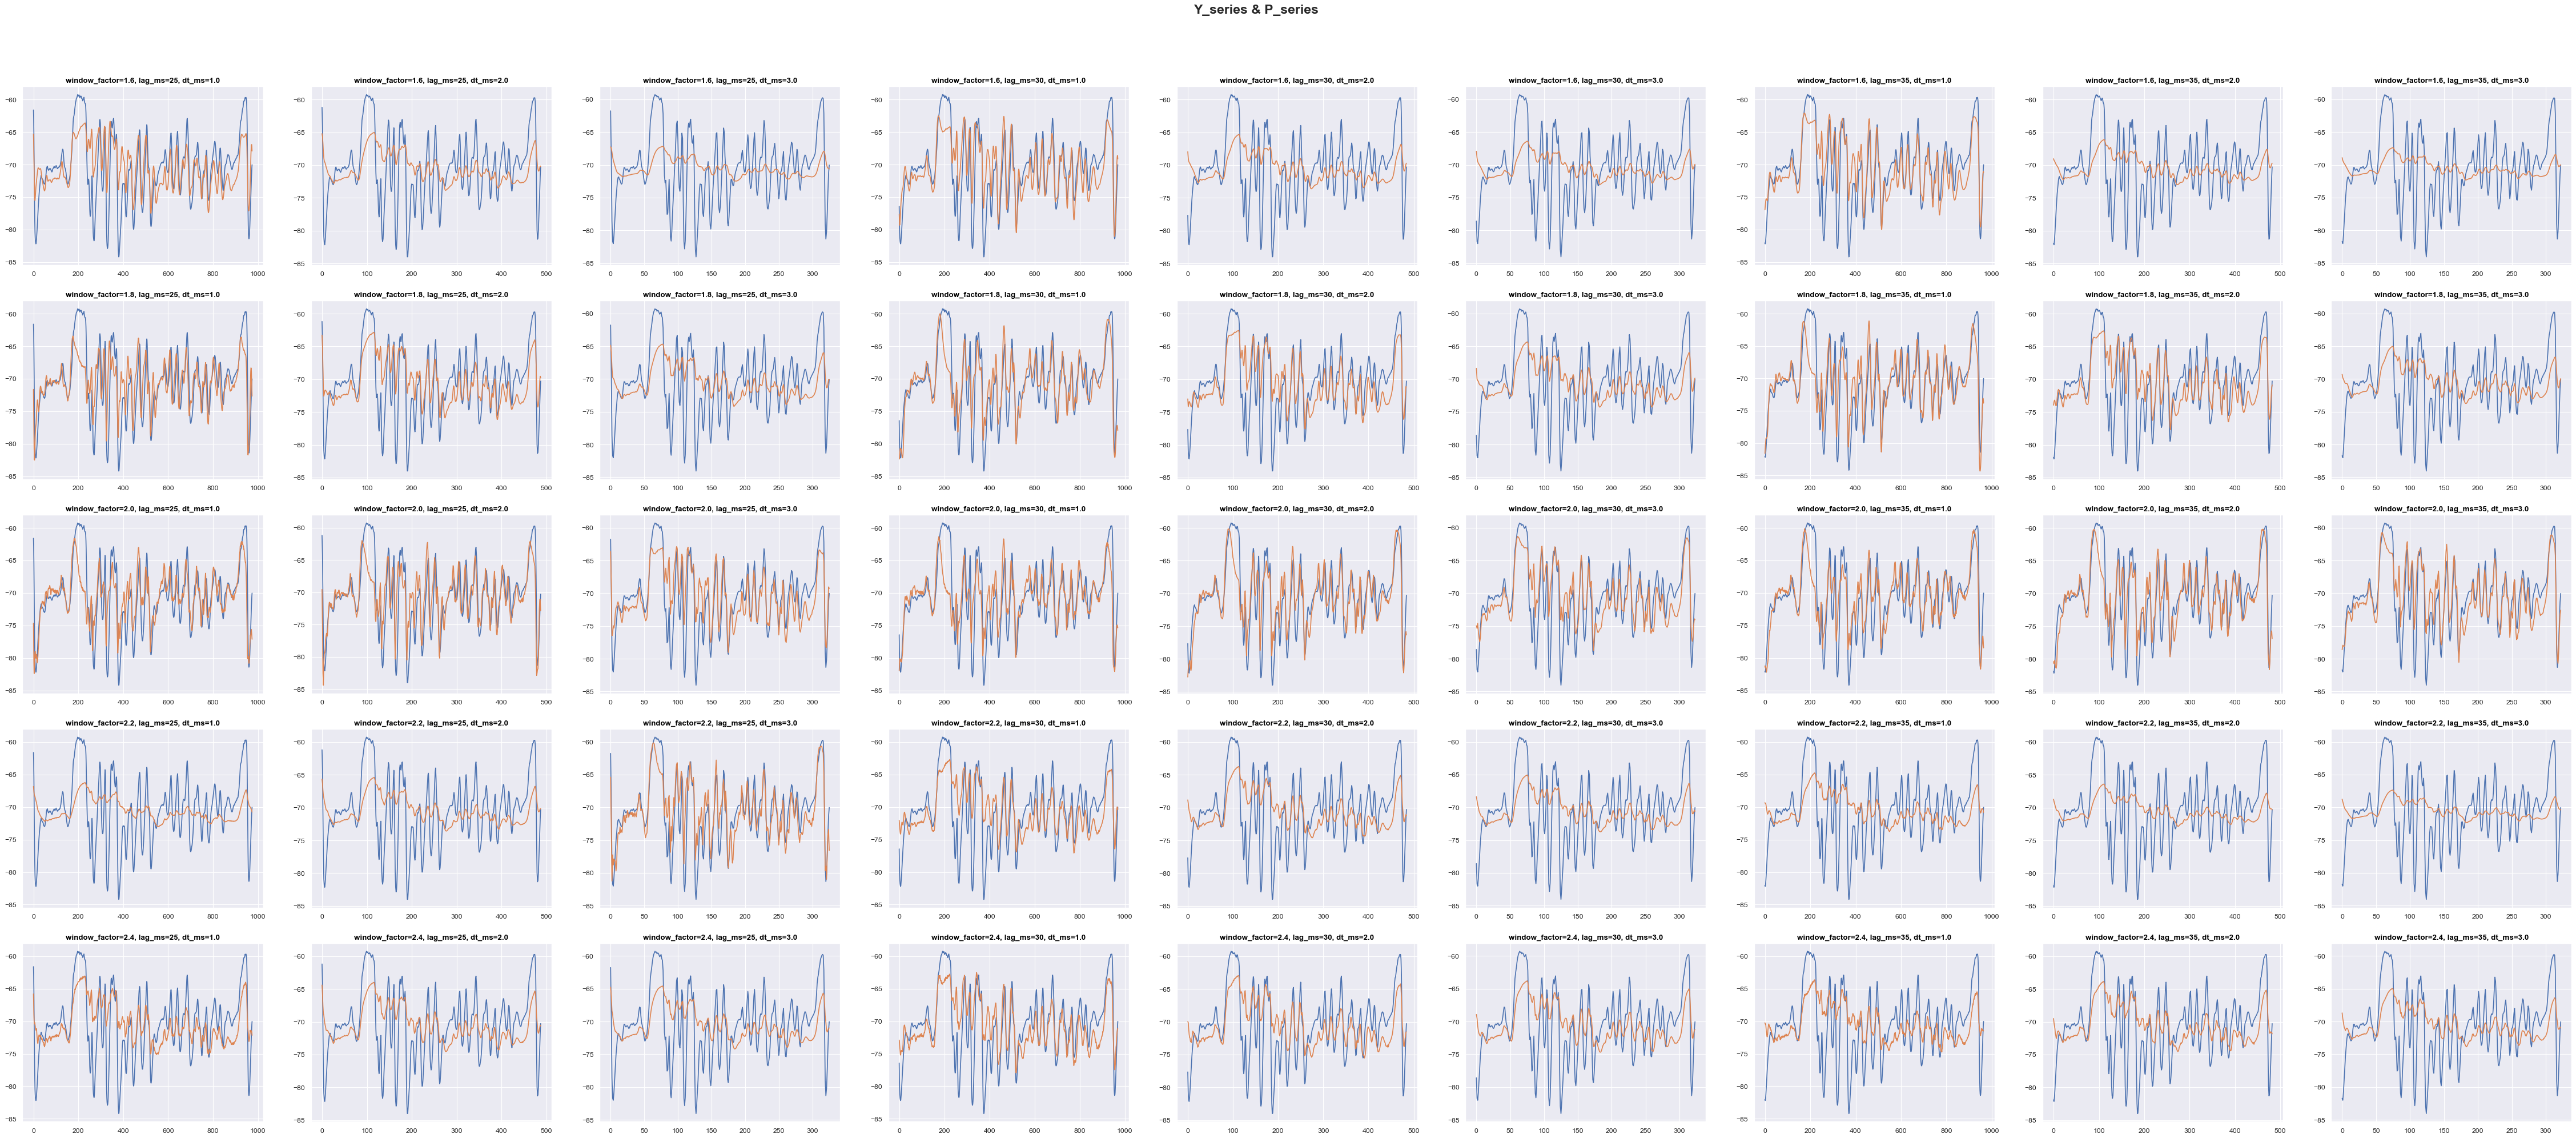

In [ ]:
plot_dataframe(results, 'X_series', x_col='Time-X', line_cols='dt_ms')
plot_dataframe(results.loc[results['method'] == 'eig-C'], 'Theta (REAL)',  title_cols=[ 'lag_ms',  'dt_ms'], val_styles=[['.-']])
plot_dataframe(results.loc[results['method'] == 'eig-C-TIME'], 'Theta (REAL)', line_cols=['window_factor'], title_cols=[ 'lag_ms',  'dt_ms'], val_styles=[['.-']])
# plot_dataframe(results, 'Residuals', title_cols=['beta'])
plot_dataframe(results.loc[results['method'] == 'eig-C-TIME'], ['Y_series', 'P_series'], title_cols=['window_factor', 'lag_ms',  'dt_ms' ])


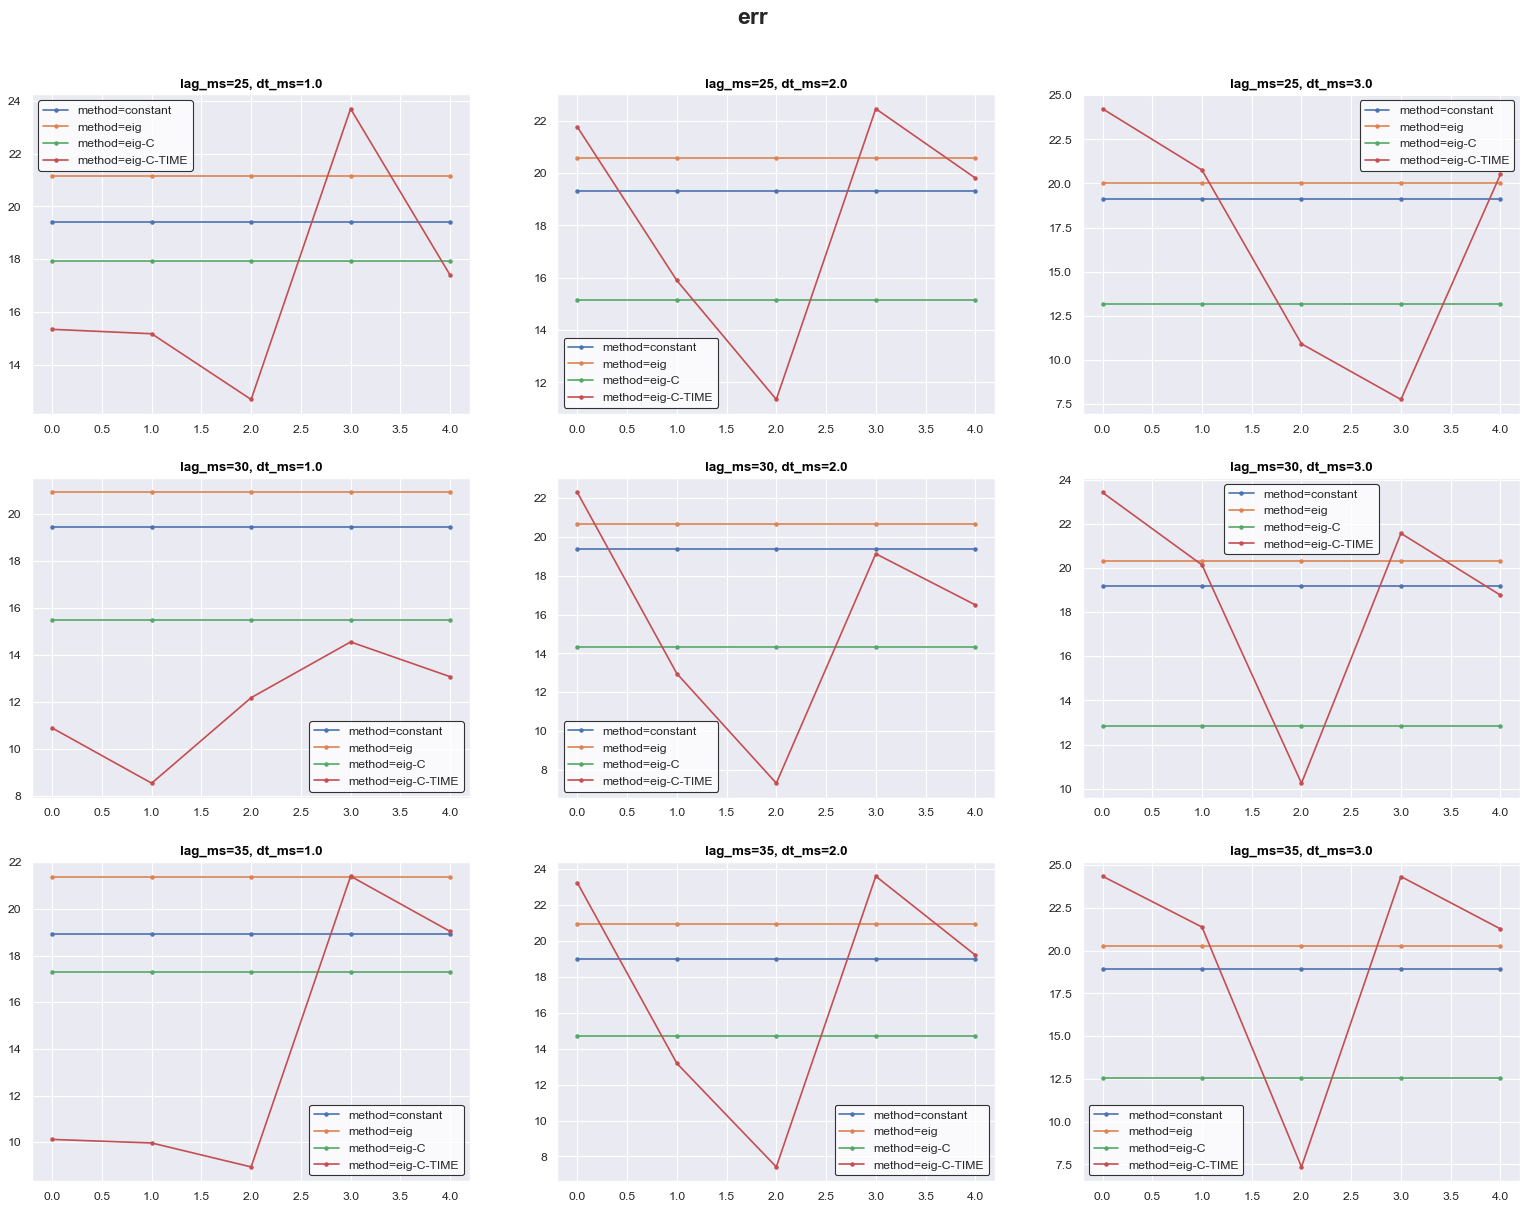

In [ ]:
plot_dataframe(results, 'err', line_cols=['method'], title_cols=['lag_ms', 'dt_ms'], aggregate='plot', legend=True, val_styles=[['.-']])